In [ ]:
import os
import sys
os.add_dll_directory(r"C:\Users\rithe\miniconda3\envs\gpuenv\lib\site-packages\torch\lib")
import torch

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.applications import DenseNet121

# from tensorflow.keras.applications import ResNet50, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
positive_folder = 'Osteoporosis Positive Images'
negative_folder = 'Osteoporosis Negative Images'

In [4]:
dfn = pd.read_csv('osteopenia_nve.csv')
dfp = pd.read_csv('osteopenia_pve.csv')

In [5]:
dfn_copy = dfn.copy()
dfp_copy = dfp.copy()
dfn_copy['filestem'] = dfn_copy['filestem'].astype(str) + '.png'
dfp_copy['filestem'] = dfp_copy['filestem'].astype(str) + '.png'
dfn_copy['osteopenia'] = 0

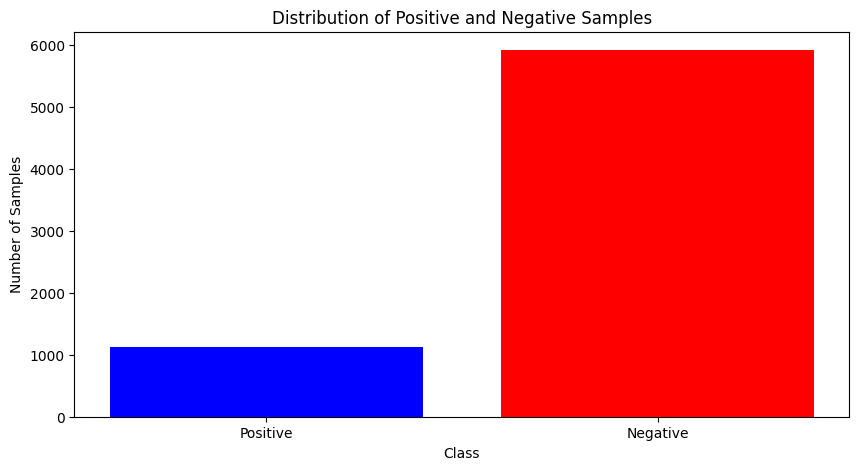

<Figure size 640x480 with 0 Axes>

In [6]:
# Function to load sample images
def load_sample_images(folder, filenames, num_samples):
    sample_images = []
    for filename in filenames[:num_samples]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            sample_images.append(img)
    return sample_images

# Load sample images from positive and negative classes
num_samples_per_class = 5

positive_sample_images = load_sample_images(positive_folder, dfp['filestem'].values, num_samples_per_class)
negative_sample_images = load_sample_images(negative_folder, dfn['filestem'].values, num_samples_per_class)

# Plot histogram showing the distribution of positive and negative samples
plt.figure(figsize=(10, 5))
plt.bar(['Positive', 'Negative'], [len(dfp), len(dfn)], color=['blue', 'red'])
plt.title('Distribution of Positive and Negative Samples')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Plot sample images from positive class
if positive_sample_images:
    plt.figure(figsize=(15, 7))
    for i in range(min(num_samples_per_class, len(positive_sample_images))):
        plt.subplot(2, num_samples_per_class, i+1)
        plt.imshow(cv2.cvtColor(positive_sample_images[i], cv2.COLOR_BGR2RGB))
        plt.title('Positive Sample')
        plt.axis('off')

# Plot sample images from negative class
if negative_sample_images:
    plt.figure(figsize=(15, 7))
    for i in range(min(num_samples_per_class, len(negative_sample_images))):
        plt.subplot(2, num_samples_per_class, i+1)
        plt.imshow(cv2.cvtColor(negative_sample_images[i], cv2.COLOR_BGR2RGB))
        plt.title('Negative Sample')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
positive_images = []
positive_filenames = []
for index, row in dfp_copy.iterrows():
    filename = row['filestem']
    img_path = os.path.join(positive_folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
        positive_images.append(img)
        positive_filenames.append(filename)

In [8]:
negative_images = []
negative_filenames = []
for index, row in dfn_copy.iterrows():
    filename = row['filestem']
    img_path = os.path.join(negative_folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
        negative_images.append(img)
        negative_filenames.append(filename)

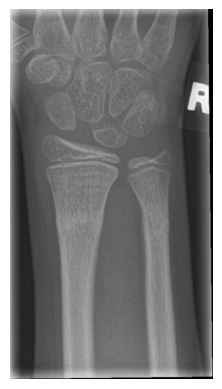

In [9]:
plt.imshow(positive_images[0])
plt.axis('off')
plt.show()

In [43]:
len(positive_images)

1130

In [44]:
len(negative_images)

5923

In [50]:
import gc
gc.collect()

0

In [13]:
# Split positive images into train, validation, and test sets
X_positive_train, X_positive_temp, y_positive_train, y_positive_temp, positive_filenames_train, positive_filenames_temp = train_test_split(positive_images, dfp_copy['osteopenia'], positive_filenames, test_size=0.4, random_state=42, stratify=dfp_copy['osteopenia'])

X_positive_val, X_positive_test, y_positive_val, y_positive_test, positive_filenames_val, positive_filenames_test = train_test_split(X_positive_temp, y_positive_temp, positive_filenames_temp, test_size=0.5, random_state=42, stratify=y_positive_temp)

# Split negative images into train, validation, and test sets
X_negative_train, X_negative_temp, y_negative_train, y_negative_temp, negative_filenames_train, negative_filenames_temp = train_test_split(negative_images, dfn_copy['osteopenia'], negative_filenames, test_size=0.4, random_state=42, stratify=dfn_copy['osteopenia'])

X_negative_val, X_negative_test, y_negative_val, y_negative_test, negative_filenames_val, negative_filenames_test = train_test_split(X_negative_temp, y_negative_temp, negative_filenames_temp, test_size=0.5, random_state=42, stratify=y_negative_temp)


In [42]:
len(X_positive_train)

678

In [41]:
len(X_negative_test)

1185

In [16]:
dfn_copy.to_csv('dfn_copy.csv')

In [40]:
X_positive_train[0].shape

(846, 543, 3)

In [39]:
#Augmentation parameters
augmentation_params = {
    'rotation_range': 20, # Rotate images by up to 20 degrees
    'width_shift_range': 0.1,  # Shift width by up to 10%
    'height_shift_range': 0.1,  # Shift height by up to 10%
    'horizontal_flip': True,  # Flip images horizontally
    'vertical_flip': False,  # Flip images vertically
    'brightness_range': [0.8, 1.2],  # Adjust brightness
    'zoom_range': 0.1,  # Zoom images by up to 10%
    'shear_range': 0.1  # Shear images by up to 10%
}

#ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=augmentation_params['rotation_range'],
    width_shift_range=augmentation_params['width_shift_range'],
    height_shift_range=augmentation_params['height_shift_range'],
    horizontal_flip=augmentation_params['horizontal_flip'],
    vertical_flip=augmentation_params['vertical_flip'],
    brightness_range=augmentation_params['brightness_range'],
    zoom_range=augmentation_params['zoom_range'],
    shear_range=augmentation_params['shear_range']
)

In [51]:
# Augment positive images with labels
X_positive_train_augmented = []
y_positive_train_augmented = []
positive_train_filenames_augmented = []  # New list for augmented file names

for img, label, filename in tqdm(zip(X_positive_train, y_positive_train, positive_filenames_train)):
    img_batch = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img_batch, batch_size=1)
    original_index = len(X_positive_train_augmented)  # Store the index of the original image

    # Append original image
    X_positive_train_augmented.append(img)
    y_positive_train_augmented.append(label)
    positive_train_filenames_augmented.append(filename)  # Original filename

    # Generate and append augmented images
    for i in range(5):  # Augment each image 5 times
        augmented_img = next(augmented_imgs)[0].astype(np.uint8)  # Convert to np.uint8
        X_positive_train_augmented.append(augmented_img)
        y_positive_train_augmented.append(label)
        augmented_filename = f"{filename[:-4]}_{i+1}.png"  # Appending _(i+1) to the original filename
        positive_train_filenames_augmented.append(augmented_filename)
#678 iterations

485it [03:13,  2.51it/s]


MemoryError: Unable to allocate 5.48 MiB for an array with shape (3, 852, 562) and data type float32

In [53]:
gc.collect()

0

In [ ]:
plt.imshow(X_positive_train_augmented[1])
plt.axis('off')
plt.show()
len(y_positive_train_augmented)

In [ ]:
positive_train_filenames_augmented[1]

In [ ]:
# # Augment positive images
# X_positive_train_augmented = []
# for img in tqdm(X_positive_train):
#     img_batch = img.reshape((1,) + img.shape)
#     augmented_imgs = datagen.flow(img_batch, batch_size=1)
#     augmented_images = [next(augmented_imgs)[0] for _ in range(5)]  # Augment each image 5 times
#     # Convert augmented images to np.uint8
#     augmented_images_uint8 = [np.uint8(image) for image in augmented_images]
#     X_positive_train_augmented.extend(augmented_images_uint8)

In [ ]:
# # Assuming X_train is your array
# X_positive_train_augmented_array = np.array(X_positive_train_augmented)
# data_type = X_positive_train_augmented_array.dtype
# print("Data type of X_positive_train_augmented:", data_type)

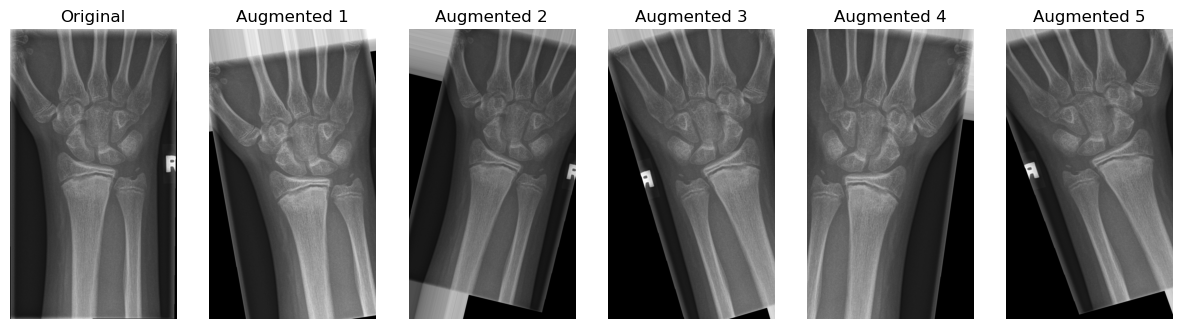

In [ ]:
index = 1  #Max index = 677 (length of X_positive_train)
num_augmented_images = 5  # Number of augmented images generated for each original image

plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_augmented_images + 1, 1)
plt.imshow(X_positive_train_augmented[index * (num_augmented_images + 1)])  # Adjusted indexing
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images + 1, i + 2)
    plt.imshow(X_positive_train_augmented[index * (num_augmented_images + 1) + i + 1])  # Adjusted indexing
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.show()

In [55]:
# Augment positive images with labels
X_positive_validation_augmented = []
y_positive_validation_augmented = []
positive_validation_filenames_augmented = []  # New list for augmented file names

for img, label, filename in tqdm(zip(X_positive_val, y_positive_val, positive_filenames_val)):
    img_batch = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img_batch, batch_size=1)
    original_index = len(X_positive_validation_augmented)  # Store the index of the original image

    # Append original image
    X_positive_validation_augmented.append(img)
    y_positive_validation_augmented.append(label)
    positive_validation_filenames_augmented.append(filename)  # Original filename

    # Generate and append augmented images
    for i in range(5):  # Augment each image 5 times
        augmented_img = next(augmented_imgs)[0].astype(np.uint8)  # Convert to np.uint8
        X_positive_validation_augmented.append(augmented_img)
        y_positive_validation_augmented.append(label)
        augmented_filename = f"{filename[:-4]}_{i+1}.png"  # Appending _(i+1) to the original filename
        positive_validation_filenames_augmented.append(augmented_filename)
#226 iterations

35it [00:17,  1.97it/s]


MemoryError: Unable to allocate 9.20 MiB for an array with shape (3, 952, 844) and data type float32

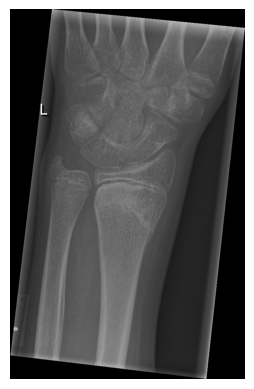

1356

In [ ]:
plt.imshow(X_positive_validation_augmented[6])
plt.axis('off')
plt.show()
len(y_positive_validation_augmented)

In [ ]:
positive_validation_filenames_augmented[6]

'4510_1224472627_05_WRI-L1_M014.png'

In [ ]:
# # Assuming X_train is your array
# X_positive_validation_gmented_array = np.array(X_positive_validation_augmented)
# data_type = X_positive_train_augmented_array.dtype
# print("Data type of X_positive_validation_augmented:", data_type)

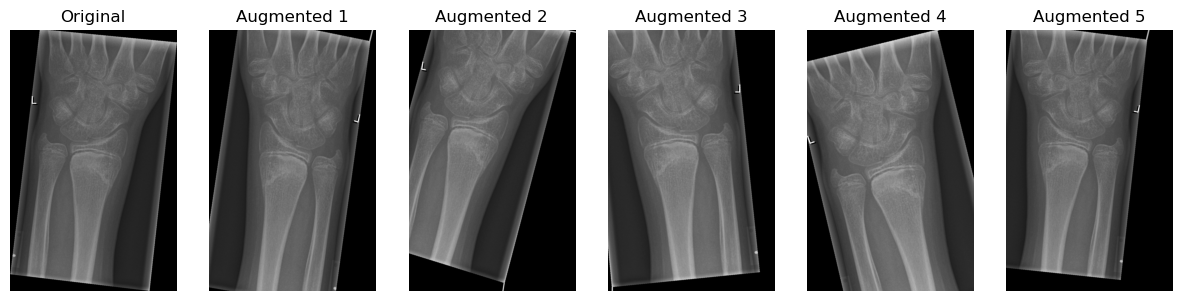

In [ ]:
index = 1  #Max index = 226 (length of X_positive_val)
num_augmented_images = 5  # Number of augmented images generated for each original image

plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_augmented_images + 1, 1)
plt.imshow(X_positive_validation_augmented[index * (num_augmented_images + 1)])  # Adjusted indexing
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images + 1, i + 2)
    plt.imshow(X_positive_validation_augmented[index * (num_augmented_images + 1) + i + 1])  # Adjusted indexing
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
# Augment positive images with labels
X_positive_testing_augmented = []
y_positive_testing_augmented = []
positive_testing_filenames_augmented = []  # New list for augmented file names

for img, label, filename in tqdm(zip(X_positive_test, y_positive_test, positive_filenames_test)):
    img_batch = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img_batch, batch_size=1)
    original_index = len(X_positive_testing_augmented)  # Store the index of the original image

    # Append original image
    X_positive_testing_augmented.append(img)
    y_positive_testing_augmented.append(label)
    positive_testing_filenames_augmented.append(filename)  # Original filename

    # Generate and append augmented images
    for i in range(5):  # Augment each image 5 times
        augmented_img = next(augmented_imgs)[0].astype(np.uint8)  # Convert to np.uint8
        X_positive_testing_augmented.append(augmented_img)
        y_positive_testing_augmented.append(label)
        augmented_filename = f"{filename[:-4]}_{i+1}.png"  # Appending _(i+1) to the original filename
        positive_testing_filenames_augmented.append(augmented_filename)
#226 iterations

226it [01:27,  2.57it/s]


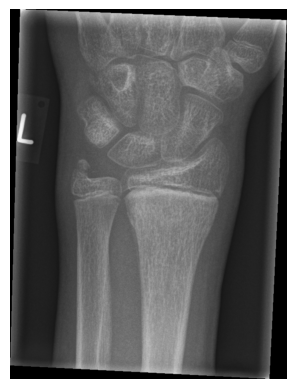

1356

In [ ]:
plt.imshow(X_positive_testing_augmented[6])
plt.axis('off')
plt.show()
len(y_positive_testing_augmented)

In [ ]:
positive_testing_filenames_augmented[6]

'1967_0619631195_04_WRI-L1_M013.png'

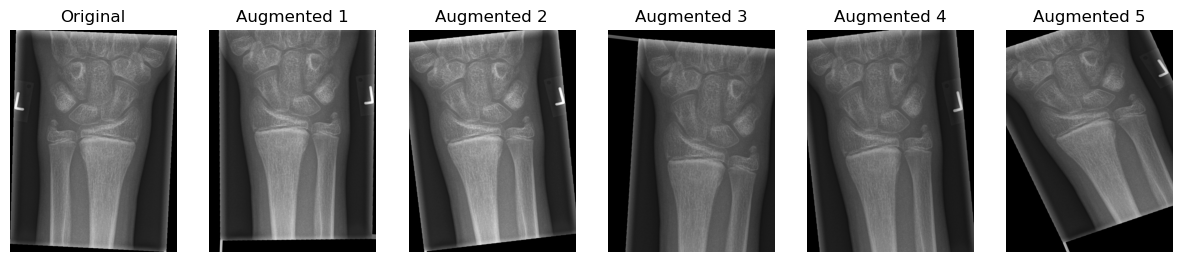

In [ ]:
index = 1  #Max index = 226 (length of X_positive_test)
num_augmented_images = 5  # Number of augmented images generated for each original image

plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_augmented_images + 1, 1)
plt.imshow(X_positive_testing_augmented[index * (num_augmented_images + 1)])  # Adjusted indexing
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images + 1, i + 2)
    plt.imshow(X_positive_testing_augmented[index * (num_augmented_images + 1) + i + 1])  # Adjusted indexing
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
print('Original positive training images:', len(X_positive_train))
print('Augmented positive training images:', len(X_positive_train_augmented))
print('Original negative training images:', len(X_negative_train))
print()
print('Original positive validation images:', len(X_positive_val))
print('Augmented positive validation images:', len(X_positive_validation_augmented))
print('Original negative validation images:', len(X_negative_val))
print()
print('Original positive testing images:', len(X_positive_test))
print('Augmented positive testing images:', len(X_positive_testing_augmented))
print('Original negative testing images:', len(X_negative_test))

Original positive training images: 678
Augmented positive training images: 4068
Original negative training images: 3553

Original positive validation images: 226
Augmented positive validation images: 1356
Original negative validation images: 1185

Original positive testing images: 226
Augmented positive testing images: 1356
Original negative testing images: 1185


In [ ]:
# # Augment negative images
# X_negative_train_augmented = []
# for img in tqdm(X_negative_train):
#     img_batch = img.reshape((1,) + img.shape)
#     augmented_imgs = datagen.flow(img_batch, batch_size=1)
#     X_negative_train_augmented.extend([next(augmented_imgs)[0] for _ in range(5)])  # Augment each image 5 times

In [ ]:
# # Function to pad images to match the dimensions of the largest image
# def pad_images(images):
#     max_height = max(img.shape[0] for img in images)
#     max_width = max(img.shape[1] for img in images)
#     padded_images = []
#     for img in images:
#         pad_height = max_height - img.shape[0]
#         pad_width = max_width - img.shape[1]
#         pad_top = pad_height // 2
#         pad_bottom = pad_height - pad_top
#         pad_left = pad_width // 2
#         pad_right = pad_width - pad_left
#         padded_img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
#         padded_images.append(padded_img)
#     return padded_images

# # Pad positive and negative training images
# X_positive_train_augmented_padded = pad_images(X_positive_train_augmented)
# X_positive_train_padded = pad_images(X_positive_train)
# X_negative_train_padded = pad_images(X_negative_train)

# # Concatenate padded positive and negative training images
# X_train_concatenated = np.concatenate((X_positive_train_augmented_padded, X_negative_train_padded))
# # Concatenate positive and negative training labels
# y_train_concatenated = np.concatenate((y_positive_train, y_negative_train))

# # Verify the shape of the concatenated arrays
# print("Shape of concatenated training images array:", X_train_concatenated.shape)
# print("Shape of concatenated training labels array:", y_train_concatenated.shape)

In [ ]:
target_size = (255, 255)
# Resize images with specified interpolation method
X_positive_train_augmented_resized = [cv2.resize(img, target_size) for img in X_positive_train_augmented]
X_negative_train_resized = [cv2.resize(img, target_size) for img in X_negative_train]

# Now, you can concatenate the resized arrays
X_train = np.concatenate((X_positive_train_augmented_resized, X_negative_train_resized))
y_train = np.concatenate((y_positive_train_augmented, y_negative_train))
train_filenames = np.concatenate((positive_train_filenames_augmented, negative_filenames_train))

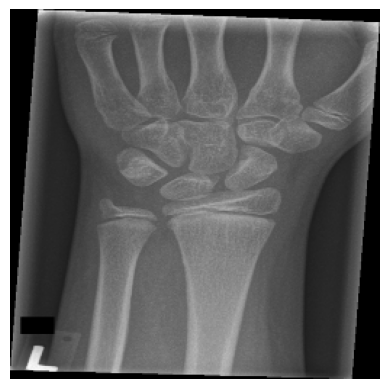

7621
7621


In [ ]:
plt.imshow(X_train[7620])
plt.axis('off')
plt.show()
print(len(X_train))
print(len(y_train))

In [ ]:
train_filenames[7620]

'4608_0925228667_01_WRI-L1_F011.png'

In [ ]:
# Resize images for validation set
target_size = (255, 255)
X_positive_val_augmented_resized = [cv2.resize(img, target_size) for img in X_positive_validation_augmented]
X_negative_val_resized = [cv2.resize(img, target_size) for img in X_negative_val]

# Concatenate the resized arrays for validation set
X_val = np.concatenate((X_positive_val_augmented_resized, X_negative_val_resized))
y_val = np.concatenate((y_positive_validation_augmented, y_negative_val))
val_filenames = np.concatenate((positive_validation_filenames_augmented, negative_filenames_val))

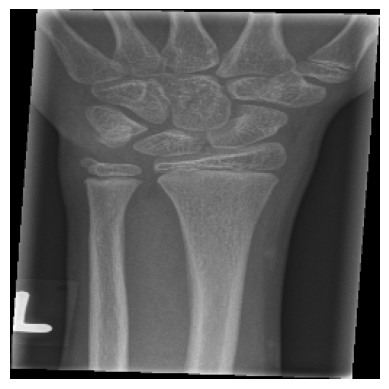

2541
2541


In [ ]:
plt.imshow(X_val[2540])
plt.axis('off')
plt.show()
print(len(X_val))
print(len(y_val))

In [ ]:
val_filenames[2540]

'3479_0091065735_01_WRI-L1_M012.png'

In [ ]:
# Resize images for testing set
target_size = (255, 255)
X_positive_test_augmented_resized = [cv2.resize(img, target_size) for img in X_positive_testing_augmented]
X_negative_test_resized = [cv2.resize(img, target_size) for img in X_negative_test]

# Concatenate the resized arrays for testing set
X_test = np.concatenate((X_positive_test_augmented_resized, X_negative_test_resized))
y_test = np.concatenate((y_positive_testing_augmented, y_negative_test))
test_filenames = np.concatenate((positive_testing_filenames_augmented, negative_filenames_test))

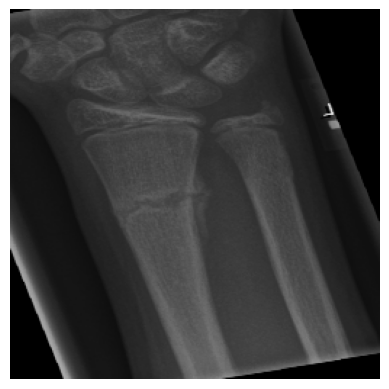

2541
2541


In [ ]:
plt.imshow(X_test[123])
plt.axis('off')
plt.show()
print(len(X_test))
print(len(y_test))

In [ ]:
test_filenames[123]

'3883_1113035129_03_WRI-L1_F010_3.png'

In [ ]:
# def resize_and_pad(img, target_size):
#     resized_img = cv2.resize(img, target_size)
#     padded_img = np.zeros((target_size[1], target_size[1], 3), dtype=np.uint8)
#     padded_img[:resized_img.shape[1], :resized_img.shape[1], :] = resized_img
#     return padded_img

# X_positive_val_augmented_resized = [resize_and_pad(img, target_size) for img in X_positive_validation_augmented]
# X_negative_val_resized = [resize_and_pad(img, target_size) for img in X_negative_val]
# X_positive_val_resized = [resize_and_pad(img, target_size) for img in X_positive_val]

In [ ]:
# # Normalize X_train to range [0, 1]
# X_train_normalized = X_train.astype('float32') / 255.0

# # Convert normalized X_train to uint8
# X_train_uint8 = (X_train_normalized * 255).astype('uint8')

In [ ]:
# print("Before conversion:", X_train.dtype)
# X_train_uint8 = (X_train * 255).astype('uint8')
# print("After conversion:", X_train_uint8.dtype)

In [ ]:
print("Minimum pixel value:", np.min(X_train))
print("Maximum pixel value:", np.max(X_train))

Minimum pixel value: 0
Maximum pixel value: 255


In [ ]:
positive_images[134].shape

(915, 382, 3)

In [ ]:
# Assuming X_train is your array
data_type = X_train.dtype
print("Data type of X_train:", data_type)

Data type of X_train: uint8


In [ ]:
# Function to find the image with the largest dimensions
def find_largest_image(positive_images):
    largest_image_index = None
    largest_height = 0
    largest_width = 0

    for i, img in enumerate(positive_images):
        height, width, _ = img.shape
        if height > largest_height:
            largest_height = height
            largest_image_index = i
        if width > largest_width:
            largest_width = width

    return largest_image_index, largest_height, largest_width

# Function to find the image with the smallest dimensions
def find_smallest_image(positive_images):
    smallest_image_index = None
    smallest_height = float('inf')
    smallest_width = float('inf')

    for i, img in enumerate(positive_images):
        height, width, _ = img.shape
        if height < smallest_height:
            smallest_height = height
            smallest_image_index = i
        if width < smallest_width:
            smallest_width = width

    return smallest_image_index, smallest_height, smallest_width


largest_image_index, largest_height, largest_width = find_largest_image(positive_images)
smallest_image_index, smallest_height, smallest_width = find_smallest_image(positive_images)

print("Image with largest dimensions:")
print("Index:", largest_image_index)
print("Height:", largest_height)
print("Width:", largest_width)

print("\nImage with smallest dimensions:")
print("Index:", smallest_image_index)
print("Height:", smallest_height)
print("Width:", smallest_width)

Image with largest dimensions:
Index: 236
Height: 1660
Width: 1489

Image with smallest dimensions:
Index: 927
Height: 464
Width: 266


In [ ]:
def find_highest_height_image(positive_images):
    highest_height_index = None
    highest_height = 0

    for i, img in enumerate(positive_images):
        height, _, _ = img.shape
        if height > highest_height:
            highest_height = height
            highest_height_index = i

    return highest_height_index, highest_height

# Function to find the image with the highest width
def find_highest_width_image(positive_images):
    highest_width_index = None
    highest_width = 0

    for i, img in enumerate(positive_images):
        _, width, _ = img.shape
        if width > highest_width:
            highest_width = width
            highest_width_index = i

    return highest_width_index, highest_width

# Function to find the image with the lowest height
def find_lowest_height_image(positive_images):
    lowest_height_index = None
    lowest_height = float('inf')

    for i, img in enumerate(positive_images):
        height, _, _ = img.shape
        if height < lowest_height:
            lowest_height = height
            lowest_height_index = i

    return lowest_height_index, lowest_height

# Function to find the image with the lowest width
def find_lowest_width_image(positive_images):
    lowest_width_index = None
    lowest_width = float('inf')

    for i, img in enumerate(positive_images):
        _, width, _ = img.shape
        if width < lowest_width:
            lowest_width = width
            lowest_width_index = i

    return lowest_width_index, lowest_width


highest_height_index, highest_height = find_highest_height_image(positive_images)
highest_width_index, highest_width = find_highest_width_image(positive_images)
lowest_height_index, lowest_height = find_lowest_height_image(positive_images)
lowest_width_index, lowest_width = find_lowest_width_image(positive_images)

print("Image with highest height:")
print("Index:", highest_height_index)
print("Height:", highest_height)

print("\nImage with highest width:")
print("Index:", highest_width_index)
print("Width:", highest_width)

print("\nImage with lowest height:")
print("Index:", lowest_height_index)
print("Height:", lowest_height)

print("\nImage with lowest width:")
print("Index:", lowest_width_index)
print("Width:", lowest_width)

Image with highest height:
Index: 236
Height: 1660

Image with highest width:
Index: 657
Width: 1489

Image with lowest height:
Index: 927
Height: 464

Image with lowest width:
Index: 723
Width: 266


In [ ]:
positive_images[657].shape

(1489, 1489, 3)

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

In [ ]:
# Load pre-trained EfficientNet model
EfficientNet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Add custom classification head
EfficientNet_x = GlobalAveragePooling2D()(EfficientNet_base_model.output)
EfficientNet_x = Dense(128, activation='relu')(EfficientNet_x)
EfficientNet_predictions = Dense(1, activation='sigmoid')(EfficientNet_x)

# Combine base model with custom head
EfficientNet_model = Model(inputs=EfficientNet_base_model.input, outputs=EfficientNet_predictions)

# Freeze base layers
for layer in EfficientNet_base_model.layers:
    layer.trainable = False

# Compile the model
EfficientNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
EfficientNet_history = EfficientNet_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Optionally, fine-tune some layers
# for layer in model.layers[-20:]:
#     layer.trainable = True

# Compile the model again
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model again (fine-tuning)
# history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
EfficientNet_test_loss, EfficientNet_test_acc = EfficientNet_model.evaluate(X_test, y_test)
print("EfficientNet Test Accuracy:", EfficientNet_test_acc)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 82s 306ms/step - accuracy: 0.8456 - loss: 0.3365 - val_accuracy: 0.9107 - val_loss: 0.2167
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 74s 309ms/step - accuracy: 0.9330 - loss: 0.1703 - val_accuracy: 0.9469 - val_loss: 0.1482
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 75s 316ms/step - accuracy: 0.9410 - loss: 0.1567 - val_accuracy: 0.9024 - val_loss: 0.2358
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 72s 301ms/step - accuracy: 0.9371 - loss: 0.1712 - val_accuracy: 0.9532 - val_loss: 0.1308
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 72s 303ms/step - accuracy: 0.9485 - loss: 0.1236 - val_accuracy: 0.9229 - val_loss: 0.1945
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 73s 306ms/step - accuracy: 0.9506 - loss: 0.1350 - val_accuracy: 0.9508 - val_loss: 0.1277
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 73s 305ms/step - accuracy: 0.9524 - loss: 0.1224 - val_accuracy: 0.9500 - val_loss: 0.1355
Epoch 8/10
239/239 ━━━━━━━━━━━━━

In [ ]:
# Evaluate the model
EfficientNet_accuracy, EfficientNet_precision, EfficientNet_recall, EfficientNet_f1, EfficientNet_roc_auc = evaluate_model(EfficientNet_model, X_test, y_test)

# Print the evaluation metrics
print("EfficientNet Evaluation Metrics:")
print(f"EfficientNet Accuracy: {EfficientNet_accuracy:.4f}")
print(f"EfficientNet Precision: {EfficientNet_precision:.4f}")
print(f"EfficientNet Recall: {EfficientNet_recall:.4f}")
print(f"EfficientNet F1-Score: {EfficientNet_f1:.4f}")
print(f"EfficientNet ROC-AUC: {EfficientNet_roc_auc:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step
EfficientNet Evaluation Metrics:
EfficientNet Accuracy: 0.9543
EfficientNet Precision: 0.9532
EfficientNet Recall: 0.9617
EfficientNet F1-Score: 0.9574
EfficientNet ROC-AUC: 0.9901


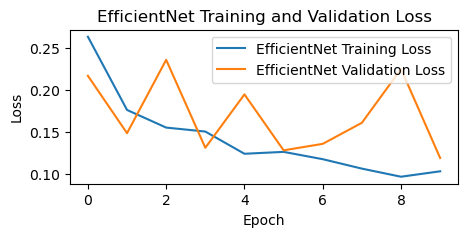

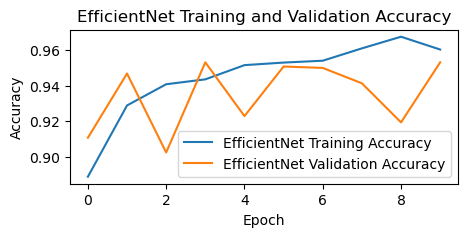

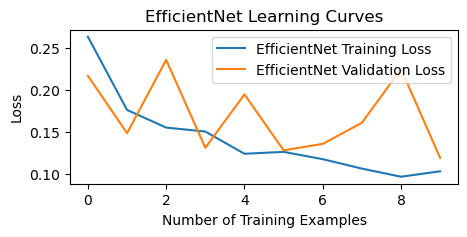

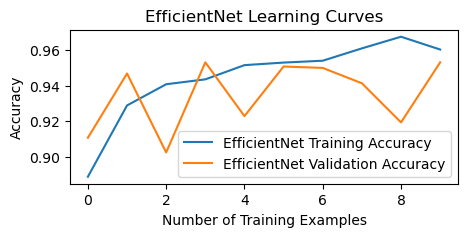

In [ ]:
# Plot training and validation loss over epochs for each model
plt.figure(figsize=(5, 2))
plt.plot(EfficientNet_history.history['loss'], label='EfficientNet Training Loss')
plt.plot(EfficientNet_history.history['val_loss'], label='EfficientNet Validation Loss')
plt.title('EfficientNet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy over epochs for each model
plt.figure(figsize=(5, 2))
plt.plot(EfficientNet_history.history['accuracy'], label='EfficientNet Training Accuracy')
plt.plot(EfficientNet_history.history['val_accuracy'], label='EfficientNet Validation Accuracy')
plt.title('EfficientNet Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Plot learning curves showing how the training and validation metrics change with the number of training examples
num_training_examples = np.arange(0, len(EfficientNet_history.history['loss']))

plt.figure(figsize=(5, 2))
plt.plot(num_training_examples, EfficientNet_history.history['loss'], label='EfficientNet Training Loss')
plt.plot(num_training_examples, EfficientNet_history.history['val_loss'], label='EfficientNet Validation Loss')
plt.title('EfficientNet Learning Curves')
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.legend()
plt.show()plt.figure(figsize=(5, 2))
plt.plot(num_training_examples, EfficientNet_history.history['accuracy'], label='EfficientNet Training Accuracy')
plt.plot(num_training_examples, EfficientNet_history.history['val_accuracy'], label='EfficientNet Validation Accuracy')
plt.title('EfficientNet Learning Curves')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load pre-trained DenseNet model
DenseNet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Add custom classification head
DenseNet_x = GlobalAveragePooling2D()(DenseNet_base_model.output)
DenseNet_x = Dense(128, activation='relu')(DenseNet_x)
DenseNet_predictions = Dense(1, activation='sigmoid')(DenseNet_x)

# Combine base model with custom head
DenseNet_model = Model(inputs=DenseNet_base_model.input, outputs=DenseNet_predictions)

# Freeze base layers
for layer in DenseNet_base_model.layers:
    layer.trainable = False

# Compile the model
DenseNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
DenseNet_history = DenseNet_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
DenseNet_test_loss, DenseNet_test_acc = DenseNet_model.evaluate(X_test, y_test)
print("DenseNet Test Accuracy:", DenseNet_test_acc)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 235s 922ms/step - accuracy: 0.7445 - loss: 0.6416 - val_accuracy: 0.8623 - val_loss: 0.3477
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 229s 958ms/step - accuracy: 0.8529 - loss: 0.3594 - val_accuracy: 0.8851 - val_loss: 0.2913
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8700 - loss: 0.3113 - val_accuracy: 0.8835 - val_loss: 0.2839
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8642 - loss: 0.3101 - val_accuracy: 0.8729 - val_loss: 0.3547
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.8860 - loss: 0.2812 - val_accuracy: 0.8957 - val_loss: 0.2702
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8865 - loss: 0.2708 - val_accuracy: 0.8910 - val_loss: 0.2774
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 234s 980ms/step - accuracy: 0.8880 - loss: 0.2683 - val_accuracy: 0.8839 - val_loss: 0.2749
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.8830 - loss: 0.2866 -

In [ ]:
# Evaluate the model
DenseNet_accuracy, DenseNet_precision, DenseNet_recall, DenseNet_f1, DenseNet_roc_auc = evaluate_model(DenseNet_model, X_test, y_test)

# Print the evaluation metrics
print("DenseNet Evaluation Metrics:")
print(f"DenseNet Accuracy: {DenseNet_accuracy:.4f}")
print(f"DenseNet Precision: {DenseNet_precision:.4f}")
print(f"DenseNet Recall: {DenseNet_recall:.4f}")
print(f"DenseNet F1-Score: {DenseNet_f1:.4f}")
print(f"DenseNet ROC-AUC: {DenseNet_roc_auc:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 635ms/step
DenseNet Evaluation Metrics:
DenseNet Accuracy: 0.8796
DenseNet Precision: 0.8877
DenseNet Recall: 0.8864
DenseNet F1-Score: 0.8871
DenseNet ROC-AUC: 0.9552


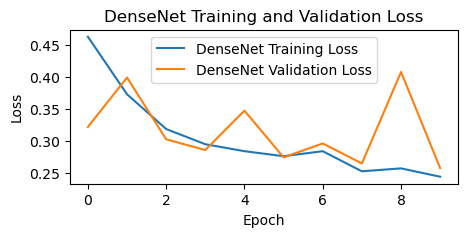

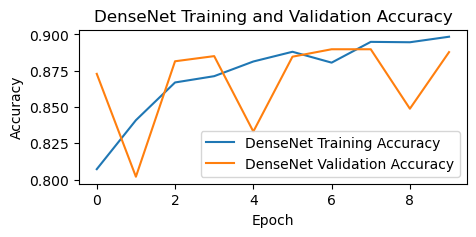

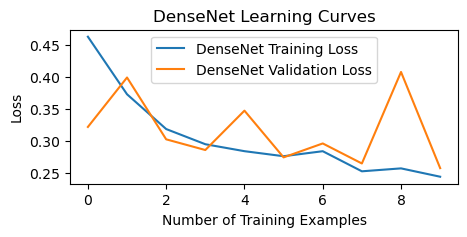

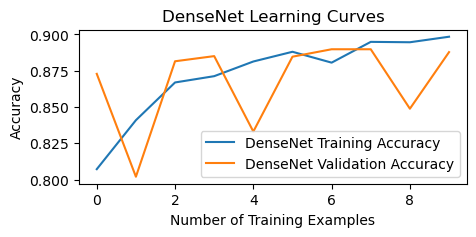

In [ ]:
plt.figure(figsize=(5, 2))
plt.plot(DenseNet_history.history['loss'], label='DenseNet Training Loss')
plt.plot(DenseNet_history.history['val_loss'], label='DenseNet Validation Loss')
plt.title('DenseNet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



plt.figure(figsize=(5, 2))
plt.plot(DenseNet_history.history['accuracy'], label='DenseNet Training Accuracy')
plt.plot(DenseNet_history.history['val_accuracy'], label='DenseNet Validation Accuracy')
plt.title('DenseNet Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(5, 2))
plt.plot(num_training_examples, DenseNet_history.history['loss'], label='DenseNet Training Loss')
plt.plot(num_training_examples, DenseNet_history.history['val_loss'], label='DenseNet Validation Loss')
plt.title('DenseNet Learning Curves')
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.legend()
plt.show()



plt.figure(figsize=(5, 2))
plt.plot(num_training_examples, DenseNet_history.history['accuracy'], label='DenseNet Training Accuracy')
plt.plot(num_training_examples, DenseNet_history.history['val_accuracy'], label='DenseNet Validation Accuracy')
plt.title('DenseNet Learning Curves')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Load pre-trained ResNeXt model
ResNeXt_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Add custom classification head
ResNeXt_x = GlobalAveragePooling2D()(ResNeXt_base_model.output)
ResNeXt_x = Dense(128, activation='relu')(ResNeXt_x)
ResNeXt_predictions = Dense(1, activation='sigmoid')(ResNeXt_x)

# Combine base model with custom head
ResNeXt_model = Model(inputs=ResNeXt_base_model.input, outputs=ResNeXt_predictions)

# Freeze base layers
for layer in ResNeXt_base_model.layers:
    layer.trainable = False

# Compile the model
ResNeXt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ResNeXt_history = ResNeXt_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
ResNeXt_test_loss, ResNeXt_test_acc = ResNeXt_model.evaluate(X_test, y_test)
print("ResNeXt Test Accuracy:", ResNeXt_test_acc)

In [ ]:
# Evaluate the model
ResNeXt_accuracy, ResNeXt_precision, ResNeXt_recall, ResNeXt_f1, ResNeXt_roc_auc = evaluate_model(ResNeXt_model, X_test, y_test)

# Print the evaluation metrics
print("ResNeXt Evaluation Metrics:")
print(f"ResNeXt Accuracy: {ResNeXt_accuracy:.4f}")
print(f"ResNeXt Precision: {ResNeXt_precision:.4f}")
print(f"ResNeXt Recall: {ResNeXt_recall:.4f}")
print(f"ResNeXt F1-Score: {ResNeXt_f1:.4f}")
print(f"ResNeXt ROC-AUC: {ResNeXt_roc_auc:.4f}")